### Download Dataset

In [ ]:
%%sh
# pip install gdown
# gdown 1jsuygnZ3G6R2lam5huSKBNXOFMCByWz9
# wget https://nlp.stanford.edu/data/glove.6B.zip
# unzip -j glove.6B.zip -d ./




In [ ]:
import pandas as pd
import numpy as np
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, LSTM,Embedding
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from tensorflow.config import list_physical_devices
list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
data_set_df = pd.read_csv('depression_dataset_reddit_cleaned.csv')

In [ ]:
data_set_df.head()

,clean_text,is_depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [ ]:
data_set_df.isnull().values.any()

False

In [ ]:
data_set_df.shape

(7731, 2)

In [ ]:
data_set_df["clean_text"][10]

'i ve been struggling with depression for a long time now but i just my first severe instance of depersonalization and it scared me so badly i m not even entirely sure why but something about the fact that i just spent over an hour lying on the floor feeling like my body didn t really belong to me and i might not be real is so extremely unsettling to me i feel more mentally and physically myself now and just trying to process what happened is really difficult if anyone ha any kind of comfort or advice about depersonalization i d appreciate it'

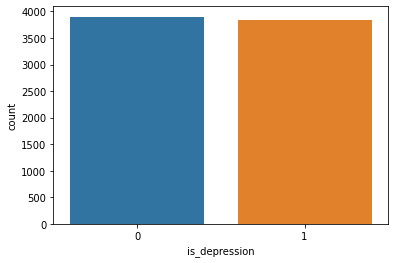

In [ ]:
sns.countplot(x='is_depression', data=data_set_df)

### Pre-processing of text
- Removing html tags
- Removing punctutations and numbers
- Removing Multiple spaces
- so on

In [ ]:
stop_words = stopwords.words('english') #English language's stop words

def textpreprocess(s):
    """This function cleans the text
    Input: string to be cleaned
    Return: string after cleaning
    """
    words = [] # empty list
    
    s = s.strip().lower() # lower the string
    s = re.sub('\[.*?\]', '', s) # removes symbols (.*?\)
    s = re.sub('https?://\S+|www\.\S+', '', s) # remove URLS
    s = re.sub('<.*?>+', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s) # remove punctuations
    s = re.sub('\n', '', s) # remove next line character
    s = re.sub('\w*\d\w*', '', s)
    
    words = s.split() # split the string into list of words
    words = [word for word in words if word not in stop_words] # removing stop words
    s = ' '.join(words) # converting list to string
    
    return s

In [ ]:
X = []
sentences = list(data_set_df['clean_text'])
for sen in sentences:
    X.append(textpreprocess(sen))

In [ ]:
X[10]

'struggling depression long time first severe instance depersonalization scared badly even entirely sure something fact spent hour lying floor feeling like body really belong might real extremely unsettling feel mentally physically trying process happened really difficult anyone ha kind comfort advice depersonalization appreciate'

In [ ]:
y = np.asarray(data_set_df['is_depression']).astype('float32').reshape((-1,1))
y

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]], dtype=float32)

### Split the dataset to train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

### Use Tokenizer to integer encode the documents

In [ ]:
# hyperparameters
num_words_ = 5000
oov_tok = "<OOV>"

tokenizer = Tokenizer(num_words=num_words_, oov_token=oov_tok)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

### Pad Sequences to create equal-length inputs

In [ ]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 500
trunc_type='post'
padding_type='post'

X_train = pad_sequences(X_train, maxlen=maxlen, truncating= trunc_type, padding=padding_type)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

### Load GloVe embedding into memory

In [ ]:
embeddings_dictionary = dict()
glove_file = open('glove.6B.50d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

### Create Embedding matrix for our Kaggle dataset

In [ ]:
embedding_matrix = np.zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Build the model - Long Short Term Memory Neural Network

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], input_length=maxlen , trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, activation='tanh', return_sequences=True))
model.add(LSTM(64, activation='tanh', return_sequences=True))
model.add(LSTM(32, activation='tanh'))
model.add(Dense(16, activation='sigmoid'))
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 50)           825150    
                                                                 
 lstm (LSTM)                 (None, 500, 128)          91648     
                                                                 
 lstm_1 (LSTM)               (None, 500, 64)           49408     
                                                                 
 lstm_2 (LSTM)               (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 979,167
Trainable params: 154,017
Non-trai

### Fit the model

In [ ]:
history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, validation_split=0.1)

Epoch 1/100
44/44 [==============================] - 13s 90ms/step - loss: 0.6969 - accuracy: 0.4965 - val_loss: 0.6960 - val_accuracy: 0.4830
Epoch 2/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6945 - accuracy: 0.4918 - val_loss: 0.6927 - val_accuracy: 0.5218
Epoch 3/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6933 - accuracy: 0.5039 - val_loss: 0.6923 - val_accuracy: 0.5024
Epoch 4/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6920 - accuracy: 0.5064 - val_loss: 0.6908 - val_accuracy: 0.4927
Epoch 5/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6920 - accuracy: 0.4985 - val_loss: 0.6889 - val_accuracy: 0.5202
Epoch 6/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6922 - accuracy: 0.4987 - val_loss: 0.6909 - val_accuracy: 0.4927
Epoch 7/100
44/44 [==============================] - 3s 66ms/step - loss: 0.6917 - accuracy: 0.5130 - val_loss: 0.6916 - val_accuracy: 0.4895
Epoch

### Evaluate Training phase

In [ ]:
score = model.evaluate(X_train, y_train, verbose=1)
score

194/194 [==============================] - 5s 23ms/step - loss: 0.0811 - accuracy: 0.9808


[0.0811488926410675, 0.9807568192481995]

In [ ]:
print("Train Loss:", score[0])
print("Train Accuracy:", score[1])

Train Loss: 0.0811488926410675
Train Accuracy: 0.9807568192481995


### Evaluate Testing phase

In [ ]:
score = model.evaluate(X_test, y_test, verbose=1)

49/49 [==============================] - 1s 25ms/step - loss: 0.1583 - accuracy: 0.9528


In [ ]:
print("Test Loss:", score[0])
print("Test Accuracy:", score[1])

Test Loss: 0.158309668302536
Test Accuracy: 0.9528118968009949


### Plot the training and testing accuracy and loss

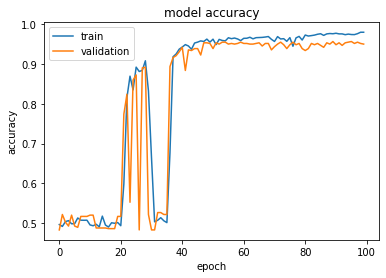

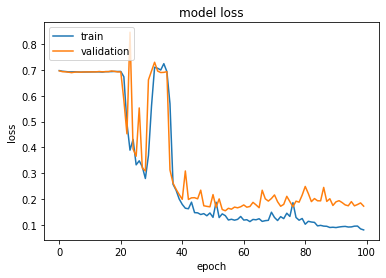

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc='upper left')
plt.show()

### Save Model

In [ ]:
model.save('./model.h5', save_format='h5')